## Analyze A/B Test Results

## Table of Contents
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='probability'></a>
### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.`a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
converted_users = (df[df['converted'] == 1].count()/df['converted'].count())[0]
converted_users

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
no_match = df.query('landing_page == "new_page" and group != "treatment"').shape[0] + df.query('group == "treatment" and landing_page != "new_page"').shape[0]
no_match

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().values.any()

False

`2. a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
treatment_old = df.query('group == "treatment" and landing_page != "new_page"')
control_new = df.query('group == "control" and landing_page != "old_page"')
df2a = df.drop(treatment_old.index)
df2 = df2a.drop(control_new.index)

In [9]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3. a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

In [12]:
df2.shape[0]

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
duplicate_user = df2[df2.duplicated(['user_id'])]
duplicate_user['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
duplicate_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop([2893])

`4.` a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2[df2['converted'] == 1].count()[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2_control = df2.query('group == "control"')
df2_control[df2_control['converted'] == 1].count()[0]/df2_control.shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2_treatment = df2.query('group == "treatment"')
df2_treatment[df2_treatment['converted'] == 1].count()[0]/df2_treatment.shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2[df2['landing_page'] == 'new_page'].count()[0]/df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

There does not appear to be sufficient evidence to conclude that the new treatment page leads to more conversions because the probability of conversion for the control group was actually higher than that for the treatment group. This supports the null hypothesis that the old page is just as good or better than the new page.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  

H<sub>0</sub> : p<sub>new</sub> - p<sub>old</sub> =< 0 

H<sub>1</sub> : p<sub>new</sub> - p<sub>old</sub> > 0

`2. a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new),p_new])
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

In [25]:
new_page_converted.mean()

0.11949624939783911

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_old),p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
old_page_converted.mean()

0.11955339565235348

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-5.7146254514375827e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []
for _ in range(10000):
    b_samp = np.random.choice(df2['group'], size=df2.shape[0], replace=True)
    n_new = np.sum(b_samp == 'treatment')
    n_old = np.sum(b_samp == 'control')
    new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new),p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_new),p_new])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  

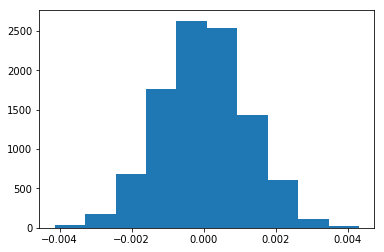

In [30]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
p_diffs = np.array(p_diffs)

In [32]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

In [33]:
(null_vals > obs_diff).mean()

0.52039999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value calculated in part j is the p-value. Having a p-value that's higher than our alpha level of 0.05 means that there is weak evidence against the null hypothesis, which means that we have failed to reject the null hypothesis. Therefore the null hypothesis that the old page is equal to or better than the new page in terms of conversions has not been rejected.

l. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. 

In [34]:
import statsmodels.api as sm
from scipy.stats import norm

convert_old = old_page_converted.mean()
convert_new = old_page_converted.mean()
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new])

In [36]:
z_score

6.0930037119967813e-05

In [37]:
p_value

0.99995138486412294

In [38]:
norm.cdf(z_score)

0.50002430756793859

In [39]:
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The p-value computed for the conversion rates is higher than the previous one, further supporting the findings from the previous sections which were that the data fails to reject the null hypothesis that the old page is equal to or better than the new page in terms of the conversion rate. The z-score is very close to zero, meaning the test was representative of the data.

<a id='regression'></a>
### Part III - Regression

`1. a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression should be used here because there are two categorical options rather than discrete or continuous numeric variables.

b. Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
df2['intercept'] = 1
df2[['treatment', 'control']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,treatment,control
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [47]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'treatment']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Aug 2019   Pseudo R-squ.:               8.077e-06
Time:                        17:14:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
treatment      0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

The p-value here is 0.190, which is different from the value found in Part II because of the difference between two-tailed tests where the alpha level is split in half to test the probability of the relationship between the variables in both directions, versus a one-tailed test where it's only being tested in one direction.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It's a good idea to consider other factors because it can increase our r-squared value, meaning the measure of how much of the variance in the dependent variable is explained by the variables being measured. This creates a better fitting model  for the data. The disadvantages of adding additional variables are that it can increase the chances of multicollinearity, where the independent variables are correlated with each other and this causes the perceived impact of them on the dependent to be less precise. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. Does it appear that country had an impact on conversion?  

In [49]:
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [51]:
df3.set_index('user_id');

In [54]:
df4 = df2.join(df3.set_index('user_id'), on='user_id')

In [55]:
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,treatment,control,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0,US


In [59]:
df4.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [62]:
df4[['UK', 'CA', 'US']] = pd.get_dummies(df4['country'])

In [63]:
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,treatment,control,country,US,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0,US,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0,US,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,US,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,US,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0,US,1,0,0


In [65]:
logit_mod = sm.Logit(df4['converted'], df4[['intercept', 'treatment', 'UK', 'CA']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [66]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 03 Aug 2019   Pseudo R-squ.:               2.323e-05
Time:                        18:33:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0042      0.009   -224.560      0.000      -2.022      -1.987
treatment      0.0149      0.011      1.307      0.191      -0.007       0.037
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
CA             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Provide the summary results, and your conclusions based on the results.

In [67]:
df4['ca_page'] = df4['treatment']*df4['CA']
df4['uk_page'] = df4['treatment']*df4['UK']

In [68]:
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,treatment,control,country,US,CA,UK,ca_page,uk_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0,US,1,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0,US,1,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,US,1,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,US,1,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0,US,1,0,0,0,0


In [69]:
logit_mod = sm.Logit(df4['converted'], df4[['intercept', 'treatment', 'UK', 'CA', 'ca_page', 'uk_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 03 Aug 2019   Pseudo R-squ.:               3.482e-05
Time:                        18:45:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0070      0.010   -207.045      0.000      -2.026      -1.988
treatment      0.0206      0.014      1.505      0.132      -0.006       0.047
UK            -0.0644      0.038     -1.679      0.093      -0.140       0.011
CA             0.0257      0.019      1.363      0.173      -0.011       0.063
ca_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
uk_page        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

Again, all of the p-values we have gotten have been too high to reject the null hypothesis that the old page is equal to or better than the new page in terms of conversion rate. From this additional analysis we can tell that the user's country is not a practically significant factor either, as they increase the r-squared, but not nearly enough to create actual significance.

In [70]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0